In [1]:
import torch
import lightning as L
import numpy as np
import cv2 as cv
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.models as models

from image import Image
from hooked_vgg import Hooked_VGG

In [10]:
i = Image(shape=(1000,2000))

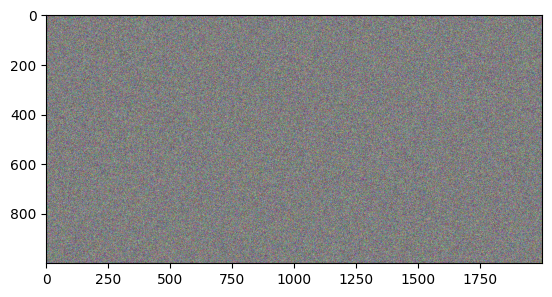

In [11]:
i.show()

In [6]:
i.rgb_img

array([[[232, 215,   4],
        [123, 215,  34],
        [143,  68,  26],
        ...,
        [126,  84,  83],
        [237,   4, 108],
        [ 93, 115,  87]],

       [[ 90,  36, 227],
        [231, 249, 250],
        [ 28, 211,  19],
        ...,
        [ 23,  53, 124],
        [114,  52,  62],
        [249, 152,  85]],

       [[ 92, 235, 119],
        [163, 141, 198],
        [153,  89,  47],
        ...,
        [ 10,  52,  16],
        [ 53, 210,  24],
        [ 97, 107,  76]],

       ...,

       [[173, 203,   0],
        [172,  72, 211],
        [230, 171, 188],
        ...,
        [253,  94, 246],
        [209, 231, 191],
        [ 48,  71,   2]],

       [[ 67, 162, 104],
        [ 90, 201,  37],
        [143, 148, 160],
        ...,
        [205,  69, 237],
        [211, 210, 160],
        [128, 119, 112]],

       [[ 27, 242, 197],
        [129, 232,  23],
        [148,  42, 226],
        ...,
        [ 39, 182,  65],
        [ 41, 108, 202],
        [124, 143, 250]]

In [3]:
i.save_to(Path('./test_images/test/allo/oui/e.jpg'))

In [7]:
img = Image(Path('./test_images/wolf_forest.jpg'))
vgg = Hooked_VGG()
# vgg.add_hooks(0)
vgg.get_features(img)

{}

In [8]:
vgg.add_hooks(0)
f = vgg.get_features(img)
vgg.remove_hooks(0)
f

{0: tensor([[[[114.1319, 160.2675, 162.3623,  ..., 143.0575, 141.9927, 112.7651],
           [ 85.8560, 108.8972, 108.4871,  ..., 101.4318, 105.1415,  99.6077],
           [ 77.8497, 105.3253, 111.9782,  ..., 146.7306, 147.1770, 126.2413],
           ...,
           [114.4016, 159.5070, 165.3801,  ..., 115.2599, 116.3856, 104.1917],
           [ 89.7675, 123.3306, 128.4945,  ..., 135.4745, 135.1688, 117.0214],
           [ 42.1564,  52.5234,  55.0601,  ...,  97.4310,  97.8944,  82.5713]],
 
          [[  0.0000, 113.8433, 124.8367,  ...,  60.5527, 102.6022, 254.9682],
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000, 254.0040],
           [  0.0000,  24.1204,  51.7621,  ...,  54.8740,  49.9264, 282.4185],
           ...,
           [  0.0000,   3.9611,  41.2950,  ...,   0.0000,   0.0000, 184.8411],
           [  0.0000,   0.0000,   0.0000,  ...,  77.2468,  45.6581, 319.7284],
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   8.0112]],
 
          [

In [9]:
vgg.hooks

{}

In [5]:
img.rgb_img

array([[[ 93, 138, 111],
        [ 97, 145, 117],
        [104, 152, 124],
        ...,
        [ 60,  71,  61],
        [ 65,  76,  66],
        [ 70,  81,  73]],

       [[ 92, 137, 110],
        [ 97, 142, 115],
        [101, 149, 121],
        ...,
        [ 72,  81,  71],
        [ 71,  82,  72],
        [ 73,  84,  76]],

       [[ 93, 138, 111],
        [ 97, 142, 115],
        [ 99, 147, 119],
        ...,
        [ 78,  86,  76],
        [ 79,  88,  78],
        [ 79,  87,  80]],

       ...,

       [[ 80,  93,  95],
        [ 75,  88,  90],
        [ 69,  82,  84],
        ...,
        [144, 150, 157],
        [147, 150, 158],
        [153, 156, 164]],

       [[ 81,  94,  96],
        [ 74,  87,  89],
        [ 66,  79,  81],
        ...,
        [ 97, 103, 110],
        [104, 110, 117],
        [136, 139, 147]],

       [[ 91, 103, 107],
        [ 67,  79,  83],
        [ 58,  70,  74],
        ...,
        [120, 126, 133],
        [105, 111, 118],
        [100, 106, 113]]

In [4]:
vgg.trainable = True
for param in vgg.vgg.parameters() :
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [7]:
img._device = 'cuda'

In [ ]:
class Test :
    def __init__(self, s : str | int):
        self.s = s
    
    def __init__(self, i : int) :
        self.s = str(i)
    
    def __init__(self, p : torch.Tensor) :
        self.s = p


class Subtest(Test) :
    def __init__(self, i : int):
        super().__init__(i)
        self.p = 0

Subtest(3.2).s

3.2

In [3]:
vgg.vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [126]:
vgg = Hooked_VGG([0,1,2,3])
print(vgg.hooks.keys())
vgg.add_hooks([5,6])
print(vgg.hooks.keys())
vgg.add_hooks(4)
print(vgg.hooks.keys())
feat1 = vgg.get_features(Image(Path('./test_images/wolf_forest.jpg')).to_tensor())
print(vgg.hooks.keys())
vgg.remove_hooks(4)
feat2 = vgg.get_features(Image(Path('./test_images/wolf_forest.jpg')).to_tensor())
vgg.remove_hooks([0,2])
feat3 = vgg.get_features(Image(Path('./test_images/wolf_forest.jpg')).to_tensor())

dict_keys([0, 1, 2, 3])
dict_keys([0, 1, 2, 3, 5, 6])
dict_keys([0, 1, 2, 3, 5, 6, 4])
dict_keys([0, 1, 2, 3, 5, 6, 4])


In [124]:
import timeit

vgg = Hooked_VGG([0,1,2,3]).to("cuda")
img = Image(Path('./test_images/wolf_forest.jpg')).to("cuda")
img_t = img.to_tensor()

%timeit vgg.get_features(img_t)

vgg.to("cpu")
img.to("cpu")
img_t = img.to_tensor()

%timeit vgg.get_features(img_t)

18.9 ms ± 175 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
445 ms ± 8.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [118]:
feat1[0].device

device(type='cuda', index=0)

In [105]:
vgg2 = Hooked_VGG()
vgg2.add_hooks([0,1])
feat4 = vgg2.get_features(Image(Path('./test_images/wolf_forest.jpg')).to_tensor())
feat4.keys()

dict_keys([0, 1])

In [82]:
feat3.keys()

dict_keys([3, 6])